In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-06-22 01:38:43.895255: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-22 01:38:44.336106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-22 01:38:44.336164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

### Loading the Full prepared dataset  cleaned data using nltk library- FakeNewsNet

In [2]:
#creating a data frame
df = pd.read_csv("Updated//full_dataset_fakenewsnet_cleaned_using_nltk.csv")

In [3]:
df['fulltext'].head(1)

0    Rick Santorum: By amending constitution, we can balance the budget for good.Rick Santorum: By amending constitution, we can balance the budget for good\n\nBy RICK SANTORUM\n\nLast summer, we saw a...
Name: fulltext, dtype: object

In [4]:
df['fulltext'].isnull().sum()

0

In [5]:
df = df[df['fulltext'].notna()]

In [6]:
df.shape

(20362, 10)

In [7]:
df['fulltext'].isnull().sum()

0

In [8]:
x=df[['fulltext']]
y=df[['class']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y, random_state=0)

### BERT Embedding Layer

In [10]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

2022-06-22 01:39:26.083024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-22 01:39:26.083388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-22 01:39:26.083687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [11]:
MAX_SEQ_LEN=256
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

- input token ids is tokenizer converts tokens using vocab file.
- input masks are either 0 or 1. 1 for useful tokens, 0 for padding.
- segment ids are either 0 or 1. For 2 text training: 0 for the first one, 1 for the second one.

In [ ]:
# Functions for constructing BERT Embeddings: input_ids, input_masks, input_segments and Inputs

In [12]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [13]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Tokenisation

In [14]:
#Create the tokenizer with the BERT layer and import it tokenizer using the original vocab file.
#Instantiate Tokenizer with vocab
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [15]:
### Helper function to create bert input array format for the given sentences

In [16]:
def create_single_input(sentence,MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

In [17]:
train_sentences=X_train.fulltext.values
train_y = y_train.values
train_inputs=create_input_array(train_sentences)

test_sentences=X_test.fulltext.values
test_y = y_test.values
test_inputs=create_input_array(test_sentences)

100%|██████████| 4073/4073 [00:30<00:00, 132.89it/s]


In [18]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");


### LSTM

In [19]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "Updated//model_Fakenews_LSTM_BERT.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

In [20]:
x= tf.keras.layers.LSTM(256)(sequence_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

lstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [21]:
clear_session()

In [22]:
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',         

In [23]:
history_lstm_bert=lstm_model.fit(train_inputs,train_y,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list_lstm) 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
66/66 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.7845 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b1bb3317ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss improved from inf to 0.48024, saving model to Updated/model_Fakenews_LSTM_BERT.h5
66/66 [==============================] - 1680s 25s/step - loss: 0.4802 - accuracy: 0.7845 - val_loss: 0.3767 - val_accuracy: 0.8432
Epoch 2/3
66/66 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8610 
Epoch 2: loss improved from 0.48024 to 0.33909, saving model to Updated/model_Fakenews_LSTM_BERT.h5
66/66 [==============================] - 1641s 25s/step - loss: 0.3391 - accuracy: 0.8610 - val_loss: 0.3478 - val_accuracy: 0.8554
Epoch 3/3
66/66 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9051 
Epoch 3: loss improved from 0.33909 to 0

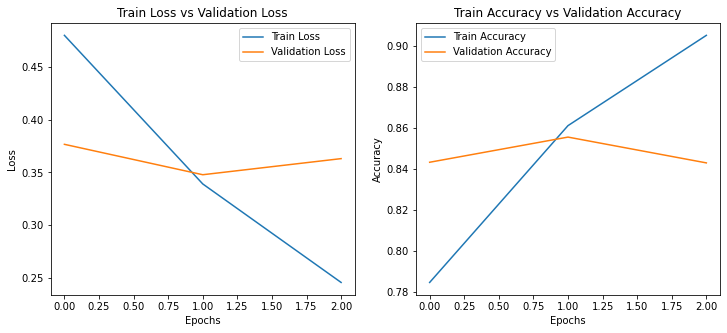

In [24]:
plot_loss_and_acc(history_lstm_bert)

### Bi-LSTM

In [25]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "Updated//model_Fakenews_BILSTM_BERT.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

In [26]:
x= tf.keras.layers.Bidirectional(LSTM(256))(sequence_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

bilstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

bilstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [27]:
clear_session()

In [28]:
bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',         

In [29]:
history_bilstm_bert=bilstm_model.fit(train_inputs,train_y,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm) 

Epoch 1/3
66/66 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9457 
Epoch 1: loss improved from inf to 0.15300, saving model to Updated/model_Fakenews_BILSTM_BERT.h5
66/66 [==============================] - 1650s 25s/step - loss: 0.1530 - accuracy: 0.9457 - val_loss: 0.4330 - val_accuracy: 0.8358
Epoch 2/3
66/66 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9678 
Epoch 2: loss improved from 0.15300 to 0.09326, saving model to Updated/model_Fakenews_BILSTM_BERT.h5
66/66 [==============================] - 1630s 25s/step - loss: 0.0933 - accuracy: 0.9678 - val_loss: 0.4997 - val_accuracy: 0.8416
Epoch 3/3
66/66 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9863 
Epoch 3: loss improved from 0.09326 to 0.04407, saving model to Updated/model_Fakenews_BILSTM_BERT.h5
66/66 [==============================] - 1624s 25s/step - loss: 0.0441 - accuracy: 0.9863 - val_loss: 0.5520 - val_accuracy: 0.8493


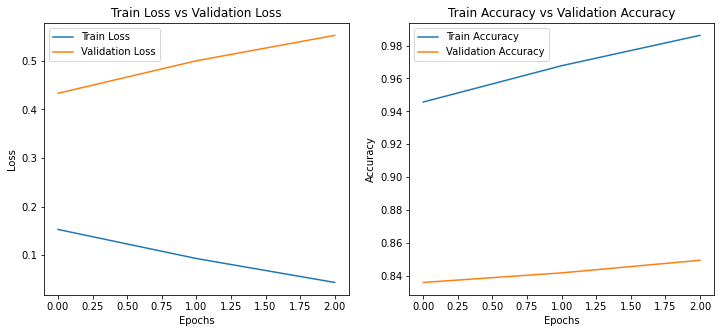

In [30]:
plot_loss_and_acc(history_bilstm_bert)